## This notebook converts VDJCounts_CC.txt, VDJCounts_CG.txt, VDJCounts_GG.txt into allVDJRatios.csv. Calculates V-usage and J-usage from counts. Filters out Pseudogenes. Only extract patids that Sharon used (N=895)

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv("VDJCounts.txt", index_col=0, low_memory=False)

In [3]:
df

,genotype,dose,transcript,count
patid,,,,
LD0691,CC,2,TRAJ1*01,1
LD0691,CC,2,TRAJ10*01,33
LD0691,CC,2,TRAJ11*01,23
LD0691,CC,2,TRAJ12*01,19
LD0691,CC,2,TRAJ13*01,1
...,...,...,...,...
LD0910,GG,0,TRBV7-9*07,305
LD0910,GG,0,TRBV9*01,47
LD0910,GG,0,TRBV9*02,28


In [4]:
df = df[df['transcript'].str.startswith("TR")] # only keep TRA

In [5]:
transcript_family_subtype_df = df["transcript"].str.split("*", n = 1, expand = True).rename(columns={0:"family", 1:"subtype"})

In [6]:
df = df.copy()

In [7]:
df.loc[:,'count'] = df['count'].astype(int)

In [8]:
df.loc[:,"family"] = transcript_family_subtype_df["family"]
df.loc[:,"subtype"] = transcript_family_subtype_df["subtype"]

In [9]:
df = df.reset_index()

In [10]:
df = df[['patid', 'family', 'subtype', 'transcript', 'count']] # we don't need to the genotype information for now

In [11]:
df

,patid,family,subtype,transcript,count
0,LD0691,TRAJ1,01,TRAJ1*01,1
1,LD0691,TRAJ10,01,TRAJ10*01,33
2,LD0691,TRAJ11,01,TRAJ11*01,23
3,LD0691,TRAJ12,01,TRAJ12*01,19
4,LD0691,TRAJ13,01,TRAJ13*01,1
...,...,...,...,...,...
275728,LD0910,TRBV7-9,07,TRBV7-9*07,305
275729,LD0910,TRBV9,01,TRBV9*01,47
275730,LD0910,TRBV9,02,TRBV9*02,28
275731,LD0910,TRBV9,03,TRBV9*03,266


In [12]:
family_count_df = df.groupby(["patid", "family"]).sum().rename(columns={"count":"family_count"}).reset_index()
family_count_df

,patid,family,family_count
0,LD0001,TRAJ1,2
1,LD0001,TRAJ10,37
2,LD0001,TRAJ11,13
3,LD0001,TRAJ12,14
4,LD0001,TRAJ13,27
...,...,...,...
165720,LD1366,TRBV7-8,366
165721,LD1366,TRBV7-9,1079
165722,LD1366,TRBV8-2,2
165723,LD1366,TRBV9,391


In [36]:
family_mean_df = family_count_df.groupby("family").mean().reset_index()

In [41]:
family_mean_df.mean()

family_count    124.613455
dtype: float64

In [39]:
family_mean_df[family_mean_df['family'] == "TRBV7-1"]

,family,family_count
189,TRBV7-1,8.3433


In [13]:
family_count_df['segment'] = family_count_df['family'].str.slice(start=2, stop=4)

In [14]:
family_count_df

,patid,family,family_count,segment
0,LD0001,TRAJ1,2,AJ
1,LD0001,TRAJ10,37,AJ
2,LD0001,TRAJ11,13,AJ
3,LD0001,TRAJ12,14,AJ
4,LD0001,TRAJ13,27,AJ
...,...,...,...,...
165720,LD1366,TRBV7-8,366,BV
165721,LD1366,TRBV7-9,1079,BV
165722,LD1366,TRBV8-2,2,BV
165723,LD1366,TRBV9,391,BV


In [15]:
segment_count_df = family_count_df.groupby(["patid", "segment"]).sum().rename(columns={"family_count":"segment_count"}).reset_index()
segment_count_df

,patid,segment,segment_count
0,LD0001,AJ,1193
1,LD0001,AV,6683
2,LD0001,BJ,2000
3,LD0001,BV,9385
4,LD0002,AJ,1765
...,...,...,...
3683,LD1364,BV,14001
3684,LD1366,AJ,1562
3685,LD1366,AV,8186
3686,LD1366,BJ,4362


In [16]:
patid_count_df = segment_count_df.groupby(["patid"]).sum().rename(columns={"segment_count":"patid_count"})

In [17]:
segment_total_df = pd.merge(segment_count_df, patid_count_df, how="inner", on=["patid"])

In [18]:
segment_total_df['segment_ratio'] = segment_total_df['segment_count'] / segment_total_df['patid_count']

In [27]:
segment_total_df.groupby("segment").mean()

,segment_count,patid_count,segment_ratio
segment,,,
AJ,1363.876356,25497.802603,0.052736
AV,7576.074837,25497.802603,0.296062
BJ,3016.983731,25497.802603,0.119659
BV,13540.867679,25497.802603,0.531543


Text(0.5, 1.0, 'Segment Ratio Boxplots for DGN')

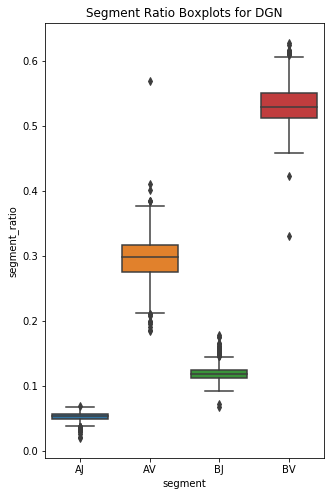

In [30]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x="segment", y="segment_ratio",
            data=segment_total_df)
plt.title("Segment Ratio Boxplots for DGN")

In [16]:
df_with_total = pd.merge(family_count_df, segment_count_df, how="inner", on=["patid", "segment"])

In [17]:
df_with_total

,patid,family,family_count,segment,segment_count
0,LD0001,TRAJ1,2,AJ,1193
1,LD0001,TRAJ10,37,AJ,1193
2,LD0001,TRAJ11,13,AJ,1193
3,LD0001,TRAJ12,14,AJ,1193
4,LD0001,TRAJ13,27,AJ,1193
...,...,...,...,...,...
165720,LD1366,TRBV7-8,366,BV,17581
165721,LD1366,TRBV7-9,1079,BV,17581
165722,LD1366,TRBV8-2,2,BV,17581
165723,LD1366,TRBV9,391,BV,17581


In [18]:
df_with_total["usage_ratio"] = df_with_total["family_count"]/df_with_total["segment_count"]
#df_with_total["patid"] = df_with_total["patid"].apply(lambda x: int(x[2:])) # get rid of "LD" in front of patid

In [19]:
df_with_total.head()

,patid,family,family_count,segment,segment_count,usage_ratio
0,LD0001,TRAJ1,2,AJ,1193,0.001676
1,LD0001,TRAJ10,37,AJ,1193,0.031014
2,LD0001,TRAJ11,13,AJ,1193,0.010897
3,LD0001,TRAJ12,14,AJ,1193,0.011735
4,LD0001,TRAJ13,27,AJ,1193,0.022632


In [20]:
vdj_df = df_with_total[["patid", "family", "usage_ratio"]]

In [36]:
"""Filter out pseudogenes and non-functional genes"""

valid_TCR_genes = set()
with open("valid_TCR_genes.txt", "r") as f:
    for line in f:
        valid_TCR_genes.add(line.strip())
vdj_df = vdj_df[vdj_df['family'].isin(valid_TCR_genes)]

In [43]:
vdj_table = vdj_df.pivot(index="patid", columns="family", values="usage_ratio").fillna(0)
vdj_table = vdj_table.reindex(sorted(vdj_table.columns), axis=1).fillna(0)
vdj_table = vdj_table.reset_index()

In [45]:
"""only want patids in Sharon's paper, N=895, due to quality control"""
sharon_counts_df = pd.read_csv("gene_counts.tsv", delimiter="\t")
sharon_counts_df = sharon_counts_df.reset_index()
sharon_ids = set(sharon_counts_df.columns[1:])
vdj_table = vdj_table[vdj_table['patid'].isin(sharon_ids)] 

In [47]:
vdj_df.to_csv("DGN_vdj_usages.csv", index=None)
vdj_table.to_csv("DGN_vdj_usages_table.csv", index=None)